# 新情绪文件单源回测（含阈值跳过、图表、状态输出）

本 Notebook 仅使用 **《情绪指标回测数据3.xlsx》**（包含情绪分数与上证/国债 T+1 收益），不再依赖旧情绪文件；
宏观同样使用 **《宏观体系打分.xlsx》**。

**功能要点**
- 新情绪（M=0，非对称 SD_up/SD_dn）+ 你的**惯性** + **两日确认**
- 宏观 5 档（固定分位）+ 两日确认
- 组合目标：`combo_opt`（宏观主导 + 情绪微调，裁剪 [0.20, 0.80]；**无覆盖**）
- 执行：真实口径/持仓单位法，仅**目标变动日**考虑；**|Δw| < 阈值** 跳过（等于阈值执行）
- 基准：**每年首个交易日开盘前**重置为 50/50；年内不再平衡
- 指标：总收益/年化/波动/夏普(2%)/最大回撤/卡玛（**百分比+两位小数**）
- 输出：绩效对比、最近一周收益、近 5/20/250 表、净值对比图（含近250日）、超额曲线、
  **仓位图（含 10/30/50/70/90% 档位；支持目标&智能错位）**、状态面板（含基准当前权重）


In [1]:
# ========== 配置 ==========
from pathlib import Path
FILE_NEW_SENT = "情绪指标回测数据3.xlsx"  # 仅用这一份
FILE_MACRO    = "宏观体系打分.xlsx"

# 年化无风险
RF_ANNUAL = 0.02

# 宏观分位 → 5 档阈值
MACRO_QUANTS = [0.20, 0.365, 0.69, 0.90]

# 仓位映射与裁剪
POS_MAP  = {2:0.80, 1:0.65, 0:0.50, -1:0.35, -2:0.20}
ADJ_MAP  = {2:0.10, 1:0.05, 0:0.00, -1:-0.05, -2:-0.10}
LOW, HIGH = 0,1

# 执行阈值（< 阈值跳过；= 阈值执行）
THRESHOLD = 0.15
SKIP_RULE = "lt"          # 'lt' or 'le'
ONLY_TARGET_CHANGE = True

# 导出
EXPORT_EXCEL = False
EXPORT_PATH = Path("Backtest_NewSent_Only.xlsx")

In [2]:
# ========== 导入与工具函数 ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置微软雅黑/黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常

# —— 两日确认 ——
def two_day_confirm(sig: pd.Series) -> pd.Series:
    s = pd.to_numeric(sig, errors='coerce').ffill().fillna(0).astype(int)
    if len(s)==0: return s
    out = [s.iloc[0]]; prev = s.iloc[0]
    for i in range(1, len(s)):
        if s.iloc[i]==s.iloc[i-1] and s.iloc[i]!=prev:
            prev = s.iloc[i]
        out.append(prev)
    return pd.Series(out, index=s.index, name="confirmed")

# —— 宏观信号（固定 5 档 + 两日确认）——
def make_macro_signal(q_series: pd.Series, quants=MACRO_QUANTS) -> pd.Series:
    def q_to_signal_5(q: float) -> int:
        if q >= quants[3]: return 2
        elif q >= quants[2]: return 1
        elif q >= quants[1]: return 0
        elif q >= quants[0]: return -1
        else: return -2
    raw = q_series.apply(q_to_signal_5).astype(int)
    return two_day_confirm(raw).rename("macro_sig")

# —— 新情绪：M=0 + 非对称 SD（参照 2024-12-31 截止样本） + 你的惯性 + 两日确认 ——
def sentiment_new_with_your_inertia(series: pd.Series, ref_end="2024-12-31") -> pd.Series:
    s = pd.to_numeric(series, errors='coerce')
    ref = s.loc[:pd.Timestamp(ref_end)]
    M = 0.0
    eps = 1e-12
    SD_up = float(ref[ref > M].std(ddof=0)) if (ref > M).any() else eps
    SD_dn = float(ref[ref < M].std(ddof=0)) if (ref < M).any() else eps
    raw = []; prev = 0
    for sc in s.values:
        if pd.isna(sc):
            raw.append(prev); continue
        if sc >= M + 2*SD_up:
            sig = 2
        elif sc >= M + SD_up:
            sig = 2 if prev == 2 else 1
        elif sc >= M:
            sig = prev if prev in (2,1) else 0
        elif sc <= M - 2*SD_dn:
            sig = -2
        elif sc <= M - SD_dn:
            sig = -2 if prev == -2 else -1
        else:
            sig = prev if prev in (-2,-1) else 0
        raw.append(sig); prev = sig
    return two_day_confirm(pd.Series(raw, index=s.index, name="sent_new_raw")).rename("sent_new")

# —— 组合目标（无覆盖）：宏观主导 + 情绪微调，裁剪 [LOW, HIGH] ——
def make_combo_opt_no_override(macro_sig: pd.Series, sent_sig: pd.Series) -> pd.Series:
    pos_macro = macro_sig.map(POS_MAP)
    pos_macro_led = (pos_macro + sent_sig.map(ADJ_MAP)).clip(LOW, HIGH)
    return pos_macro_led.rename("pos_combo_opt")

# —— 真实口径执行：仅目标变动日；<阈值跳过（=阈值执行） ——
def run_engine_with_threshold(eq_ret: pd.Series, bd_ret: pd.Series, target_pos: pd.Series,
                              threshold: float = 0.15, skip_rule: str = "lt",
                              only_target_change_days: bool = True) -> pd.DataFrame:
    eq = pd.Series(eq_ret).astype(float)
    bd = pd.Series(bd_ret).astype(float)
    tp = pd.Series(target_pos).ffill().clip(0,1).astype(float)
    reb = (tp != tp.shift(1)).fillna(True) if only_target_change_days else pd.Series(True, index=tp.index)

    n = len(eq)
    eq_v = 0.5; bd_v = 0.5
    nav = np.zeros(n); r = np.zeros(n); w_eq = np.zeros(n); w_pre = np.zeros(n)
    executed = np.zeros(n, dtype=bool); skipped = np.zeros(n, dtype=bool)
    considered = np.zeros(n, dtype=bool); diff = np.zeros(n)

    # day 0
    w_pre[0] = eq_v/(eq_v+bd_v)
    if reb.iloc[0]:
        considered[0] = True
        diff0 = abs(tp.iloc[0] - w_pre[0]); diff[0] = diff0
        do_exec = (diff0 >= threshold) if (skip_rule=="lt") else (diff0 > threshold)
        if do_exec:
            total = eq_v+bd_v
            eq_v = total*tp.iloc[0]; bd_v = total*(1-tp.iloc[0]); executed[0] = True
        else:
            skipped[0] = True
    eq_v *= (1+eq.iloc[0]); bd_v *= (1+bd.iloc[0])
    nav[0] = eq_v+bd_v; r[0] = nav[0]-1.0; w_eq[0] = eq_v/nav[0]

    # days 1..n-1
    for i in range(1, n):
        w_pre[i] = eq_v/(eq_v+bd_v)
        if reb.iloc[i]:
            considered[i] = True
            diff[i] = abs(tp.iloc[i] - w_pre[i])
            do_exec = (diff[i] >= threshold) if (skip_rule=="lt") else (diff[i] > threshold)
            if do_exec:
                total = eq_v+bd_v
                eq_v = total*tp.iloc[i]; bd_v = total*(1-tp.iloc[i]); executed[i] = True
            else:
                skipped[i] = True
        eq_v *= (1+eq.iloc[i]); bd_v *= (1+bd.iloc[i])
        nav[i] = eq_v+bd_v; r[i] = nav[i]/nav[i-1] - 1.0; w_eq[i] = eq_v/nav[i]

    return pd.DataFrame({"nav":nav, "r_port":r, "w_eq":w_eq, "w_pre":w_pre,
                         "executed":executed.astype(int), "skipped":skipped.astype(int),
                         "considered":considered.astype(int), "diff":diff}, index=eq.index)

# —— 绩效（百分号 + 两位小数） ——
def perf(nav: pd.Series, rf: float = 0.02) -> dict:
    nav = nav.dropna()
    total = (nav.iloc[-1] / nav.iloc[0] - 1) * 100
    ann = ((nav.iloc[-1] / nav.iloc[0]) ** (252 / len(nav)) - 1) * 100
    r = nav.pct_change().dropna()
    vol = r.std(ddof=1) * (252 ** 0.5) * 100
    sharpe = (ann - rf * 100) / vol if vol > 0 else np.nan
    mdd = ((nav.cummax() - nav) / nav.cummax()).max() * 100
    calmar = ann / mdd if mdd > 0 else np.nan
    return {"总收益": f"{total:.2f}%","年化收益": f"{ann:.2f}%","年化波动": f"{vol:.2f}%",
            "夏普比率": f"{sharpe:.2f}","最大回撤": f"{mdd:.2f}%","卡玛比率": f"{calmar:.2f}"}

# —— 基准：年度 50/50 再平衡（新年首日开盘前重置） ——
def build_benchmark_buyhold(eq_ret: pd.Series, bd_ret: pd.Series, w0=0.5):
    idx = eq_ret.index
    eq = eq_ret.values; bd = bd_ret.values
    n = len(eq)
    eq_v = w0; bd_v = 1.0 - w0
    nav = np.zeros(n, dtype=float)
    years = pd.Index(idx).year
    # day 0
    eq_v *= (1 + eq[0]); bd_v *= (1 + bd[0]); nav[0] = eq_v + bd_v
    for i in range(1, n):
        if years[i] != years[i-1]:
            total = eq_v + bd_v
            eq_v = total * w0; bd_v = total * (1.0 - w0)
        eq_v *= (1 + eq[i]); bd_v *= (1 + bd[i])
        nav[i] = eq_v + bd_v
    return pd.Series(nav, index=idx, name="Benchmark_NAV")

# —— 宏观文件鲁棒读取 ——
def _read_macro_robust(file_macro: str) -> pd.DataFrame:
    sheets = pd.read_excel(file_macro, sheet_name=None)
    macro_df = None
    for name, df in sheets.items():
        if df is None or df.empty: continue
        df = df.copy(); df.columns = [str(c).strip() for c in df.columns]
        # 日期列
        date_alias = [c for c in df.columns if str(c).strip().lower() in ("date","日期","交易日期")]
        if date_alias:
            date_col = date_alias[0]
        else:
            c0 = df.columns[0]
            can_parse = pd.to_datetime(df[c0], errors="coerce").notna().mean() >= 0.5
            if not can_parse: continue
            date_col = c0
        # 宏观分位列
        cand = [c for c in df.columns if ("宏观" in c) or ("分位" in c)]
        if not cand: continue
        macro_col = cand[0]
        tmp = df[[date_col, macro_col]].copy()
        tmp.rename(columns={date_col:"Date", macro_col:"宏观打分历史分位数"}, inplace=True)
        tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
        tmp = tmp.dropna(subset=["Date","宏观打分历史分位数"]).sort_values("Date")
        macro_df = tmp; break
    if macro_df is None:
        raise ValueError("未在《宏观体系打分.xlsx》找到含日期与宏观分位的表。")
    return macro_df

# —— 新情绪文件鲁棒读取（一次性读：日期/总得分/上证T+1/国债T+1） ——
def _read_new_sent_robust(file_new: str) -> pd.DataFrame:
    sheets = pd.read_excel(file_new, sheet_name=None)
    ok = None
    for name, df in sheets.items():
        if df is None or df.empty: continue
        df = df.copy(); df.columns = [str(c).strip() for c in df.columns]
        # 日期
        date_alias = [c for c in df.columns if str(c).strip().lower() in ("date","日期","交易日期")]
        if not date_alias:
            continue
        date_col = date_alias[0]
        # 情绪分数
        score_col = None
        for c in df.columns:
            if c in ("总得分","情绪总得分","情绪分数","情绪得分"):
                score_col = c; break
        if score_col is None: continue
        # 股票/债券 T+1 收益
        eq_col = None; bd_col = None
        for c in df.columns:
            if ("上证" in c and "T+1" in c and "收益" in c) or c == "上证指数T+1收益率":
                eq_col = c
            if ("国债" in c and "T+1" in c and "收益" in c) or c == "国债指数T+1收益率":
                bd_col = c
        if eq_col is None or bd_col is None:
            continue
        tmp = df[[date_col, score_col, eq_col, bd_col]].copy()
        tmp.columns = ["Date","score_new","eq_t1","bd_t1"]
        tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
        tmp = tmp.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
        ok = tmp; break
    if ok is None:
        raise ValueError("未在《情绪指标回测数据3.xlsx》找到必要列（日期/总得分/上证T+1/国债T+1）。")
    return ok

# —— 统一对齐 ——
def load_and_align(file_new=FILE_NEW_SENT, file_macro=FILE_MACRO):
    new_df = _read_new_sent_robust(file_new)
    macro = _read_macro_robust(file_macro)
    panel = pd.merge_asof(new_df.sort_values("Date"),
                          macro.sort_values("Date"),
                          on="Date", direction="backward")
    panel = panel.dropna(subset=["宏观打分历史分位数"]).reset_index(drop=True)
    panel["ret_eq"] = panel["eq_t1"]/100.0
    panel["ret_bd"] = panel["bd_t1"]/100.0
    panel = panel.set_index("Date")
    return panel

def build_benchmark_buyhold_panel(panel):
    return build_benchmark_buyhold(panel['ret_eq'], panel['ret_bd'], w0=0.5)

def sig_text(x: int) -> str:
    m = {2:"强风险偏好(+2)", 1:"偏风险(+1)", 0:"中性/惯性(0)", -1:"偏避险(-1)", -2:"强避险(-2)"}
    try: return m[int(x)]
    except: return str(x)

In [3]:
# ========== 读数与信号 ==========
panel = load_and_align(FILE_NEW_SENT, FILE_MACRO)

macro_sig = make_macro_signal(panel['宏观打分历史分位数'])
sent_new  = sentiment_new_with_your_inertia(panel['score_new'])
pos_new   = make_combo_opt_no_override(macro_sig, sent_new)

# panel.head()

In [4]:
# ========== 执行（真实口径；<阈值跳过；=阈值执行） ==========
run = run_engine_with_threshold(panel['ret_eq'], panel['ret_bd'], pos_new,
                                threshold=THRESHOLD, skip_rule=SKIP_RULE,
                                only_target_change_days=ONLY_TARGET_CHANGE)
# run.tail()

In [5]:
# ========== 绩效对比（组合 vs 基准） + 最近一周 ==========
bench = build_benchmark_buyhold_panel(panel)

# 绩效
port_perf  = perf(run['nav'], rf=RF_ANNUAL)
bench_perf = perf(bench, rf=RF_ANNUAL)

perf_cols = ["总收益","年化收益","年化波动","夏普比率","最大回撤","卡玛比率"]
perf_comp = pd.DataFrame({
    "组合": [port_perf[c] for c in perf_cols],
    "基准": [bench_perf[c] for c in perf_cols],
}, index=perf_cols)

# 执行统计
exec_summary = pd.DataFrame([{
    "Sample": f"{run.index[0].date()} → {run.index[-1].date()}",
    "Rebalance Considered": int(run['considered'].sum()),
    "Executed": int(run['executed'].sum()),
    "Skipped": int(run['skipped'].sum()),
    "Avg |Δw| (considered)": float(np.nanmean(run.loc[run['considered']==1, 'diff'])),
    "Avg |Δw| (executed)": float(np.nanmean(run.loc[run['executed']==1, 'diff'])) if (run['executed']==1).any() else np.nan,
    "Avg |Δw| (skipped)": float(np.nanmean(run.loc[run['skipped']==1, 'diff'])) if (run['skipped']==1).any() else np.nan,
}])

display(perf_comp)
display(exec_summary)

# 最近一周（5个交易日）
port_r = run['r_port'].copy()
bench_r = bench.pct_change(); bench_r.iloc[0] = bench.iloc[0] - 1.0

recent = pd.DataFrame({"Portfolio": port_r.tail(5), "Benchmark": bench_r.tail(5)})
recent["Excess"] = recent["Portfolio"] - recent["Benchmark"]

week_summary = pd.DataFrame([{
    "时间区间": f"{recent.index[0].date()} → {recent.index[-1].date()}",
    "组合最近一周收益": f"{((1 + recent['Portfolio']).prod() - 1) * 100:.2f}%",
    "基准最近一周收益": f"{((1 + recent['Benchmark']).prod() - 1) * 100:.2f}%",
    "组合最近一周超额": f"{(((1 + recent['Portfolio']).prod() - 1) - ((1 + recent['Benchmark']).prod() - 1)) * 100:.2f}%"
}])

display(week_summary)

,组合,基准
总收益,80.49%,33.27%
年化收益,11.60%,5.48%
年化波动,8.43%,7.98%
夏普比率,1.14,0.44
最大回撤,7.44%,10.31%
卡玛比率,1.56,0.53


,Sample,Rebalance Considered,Executed,Skipped,Avg |Δw| (considered),Avg |Δw| (executed),Avg |Δw| (skipped)
0,2020-04-13 → 2025-11-14,196,73,123,0.134032,0.230529,0.076762


C:\Users\Haochen\AppData\Local\Temp\ipykernel_29484\3039232269.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  bench_r = bench.pct_change(); bench_r.iloc[0] = bench.iloc[0] - 1.0


,时间区间,组合最近一周收益,基准最近一周收益,组合最近一周超额
0,2025-11-10 → 2025-11-14,-0.33%,-0.38%,0.04%


In [6]:
# ========== 最近 5 / 20 / 250 个交易日表（总收益/超额/最大回撤） ==========
def window_metrics(nav_port: pd.Series, nav_bench: pd.Series, n: int):
    p = nav_port.dropna(); b = nav_bench.reindex(p.index).dropna()
    idx = p.index.intersection(b.index); p = p.loc[idx]; b = b.loc[idx]
    if len(p) < 2: return np.nan, np.nan, np.nan
    p_win = p.tail(n); b_win = b.reindex(p_win.index)
    p_norm = p_win / p_win.iloc[0]; b_norm = b_win / b_win.iloc[0]
    tot = p_norm.iloc[-1] - 1.0
    ex  = (p_norm.iloc[-1]-1.0) - (b_norm.iloc[-1]-1.0)
    mdd = ((p_norm.cummax()-p_norm)/p_norm.cummax()).max()
    return tot, ex, mdd

rows = []
for n, tag in [(5, "近5个交易日"), (20, "近20个交易日"), (250, "近250个交易日")]:
    tot, ex, mdd = window_metrics(run['nav'], bench, n)
    rows.append({
        "区间": tag,
        "组合总收益": f"{tot*100:.2f}%",
        "组合超额收益": f"{ex*100:.2f}%",
        "组合最大回撤": f"{mdd*100:.2f}%",
    })
period_table = pd.DataFrame(rows)
display(period_table)

,区间,组合总收益,组合超额收益,组合最大回撤
0,近5个交易日,-0.33%,0.04%,0.48%
1,近20个交易日,1.76%,-0.17%,0.69%
2,近250个交易日,13.82%,3.00%,3.12%


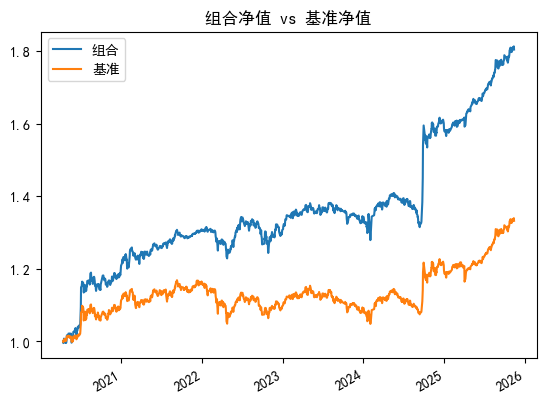

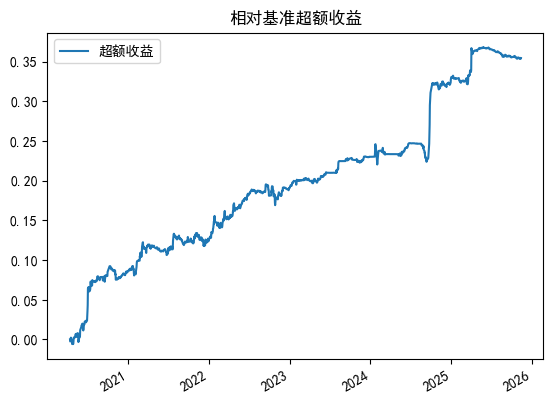

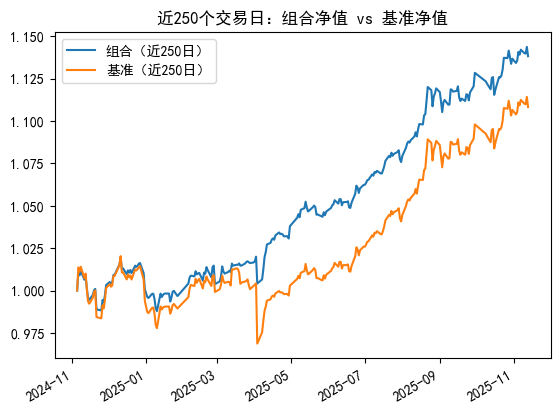

In [7]:
# ========== 图表：净值对比 / 超额曲线 / 近250日净值 ==========
port_nav_norm  = run['nav'] / run['nav'].iloc[0]
bench_nav_norm = bench / bench.iloc[0]

# 图1：组合 vs 基准净值
plt.figure()
plt.plot(port_nav_norm.index, port_nav_norm.values, label="组合")
plt.plot(bench_nav_norm.index, bench_nav_norm.values, label="基准")
plt.title("组合净值 vs 基准净值")
plt.legend(); plt.gcf().autofmt_xdate(); plt.show()

# 图2：组合超额（相对净值 - 1）
excess_curve = (port_nav_norm / bench_nav_norm) - 1.0
plt.figure()
plt.plot(excess_curve.index, excess_curve.values, label="超额收益")
plt.title("相对基准超额收益")
plt.legend(); plt.gcf().autofmt_xdate(); plt.show()

# 图3：近250日净值
N = 250
p_nav = run['nav'].dropna(); b_nav = bench.reindex(p_nav.index).dropna()
common = p_nav.index.intersection(b_nav.index)
p_win = p_nav.loc[common].tail(N); b_win = b_nav.loc[common].tail(N)
if len(p_win) >= 2:
    p_win_n = p_win / p_win.iloc[0]; b_win_n = b_win / b_win.iloc[0]
    plt.figure()
    plt.plot(p_win_n.index, p_win_n.values, label="组合（近250日）")
    plt.plot(b_win_n.index, b_win_n.values, label="基准（近250日）")
    plt.title("近250个交易日：组合净值 vs 基准净值")
    plt.legend(); plt.gcf().autofmt_xdate(); plt.show()

In [8]:
# ========== 仓位图函数（固定 10/30/50/70/90% 档位、目标、智能错位、可调整颜色） ==========
def plot_weight_with_levels(
    run_df, pos_new=None, nearest='nearest', show_target=True,
    close_thresh=0.02, levels=(0.10, 0.30, 0.50, 0.70, 0.90),
    level_color=None, level_colors=None, level_linewidth=1.2, level_alpha=0.9, level_linestyle='--'
):
    w_eq = run_df['w_eq'].dropna()
    fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
    # 实际
    ax.plot(w_eq.index, w_eq.values, linewidth=2, label='实际权益权重 w_eq')
    # 目标
    tgt = None
    if show_target and (pos_new is not None):
        tgt = pd.Series(pos_new).reindex(w_eq.index).ffill()
        ax.plot(tgt.index, tgt.values, linewidth=1.5, linestyle='-', label='目标权益权重 target_pos')
    # 档位
    for i, y in enumerate(levels):
        kw = dict(linestyle=level_linestyle, linewidth=level_linewidth, alpha=level_alpha, zorder=0.5,
                  label='调仓档位' if i == 0 else None)
        if level_colors is not None: kw['color'] = level_colors[i]
        elif level_color is not None: kw['color'] = level_color
        ax.axhline(y, **kw)
    # y 轴刻度
    ax.set_yticks(list(levels)); ax.set_yticklabels([f"{v:.0%}" for v in levels])
    # x 轴日期
    locator = mdates.AutoDateLocator(minticks=5, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator); ax.xaxis.set_major_formatter(formatter)
    # 样式
    ax.grid(True, which='major', linestyle=':', linewidth=0.8, alpha=0.6)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    # 标注
    cur_x = w_eq.index[-1]; cur_y = float(w_eq.iloc[-1])
    if nearest == 'down':
        near = max([v for v in levels if v <= cur_y], default=levels[0])
    elif nearest == 'up':
        near = min([v for v in levels if v >= cur_y], default=levels[-1])
    else:
        near = min(levels, key=lambda v: abs(v - cur_y))
    tgt_y = float(tgt.iloc[-1]) if tgt is not None else None
    if tgt_y is None:
        ann1_xytext, ann2_xytext = (10, 10), None
    else:
        dy = cur_y - tgt_y
        if abs(dy) < close_thresh:
            ann1_xytext, ann2_xytext = (12, 16), (-60, -18)
        elif dy > 0:
            ann1_xytext, ann2_xytext = (10, 12), (10, -18)
        else:
            ann1_xytext, ann2_xytext = (10, -18), (10, 12)
    ax.plot([cur_x], [cur_y], marker='o', markersize=4)
    ax.annotate(f"当前实际：{cur_y:.2%}\n最近档位：{near:.0%}",
                xy=(cur_x, cur_y), xytext=ann1_xytext, textcoords='offset points',
                ha='left' if ann1_xytext[0] >= 0 else 'right',
                va='bottom' if ann1_xytext[1] >= 0 else 'top')
    if tgt_y is not None:
        ax.annotate(f"当前目标：{tgt_y:.2%}",
                    xy=(cur_x, tgt_y), xytext=ann2_xytext, textcoords='offset points',
                    ha='left' if ann2_xytext[0] >= 0 else 'right',
                    va='bottom' if ann2_xytext[1] >= 0 else 'top')
    ax.legend(loc='best', frameon=False)
    plt.show()

In [9]:
pos_new.iloc[-10:]

Date
2025-11-03    0.40
2025-11-04    0.40
2025-11-05    0.40
2025-11-06    0.40
2025-11-07    0.40
2025-11-10    0.40
2025-11-11    0.55
2025-11-12    0.55
2025-11-13    0.55
2025-11-14    0.55
Name: pos_combo_opt, dtype: float64

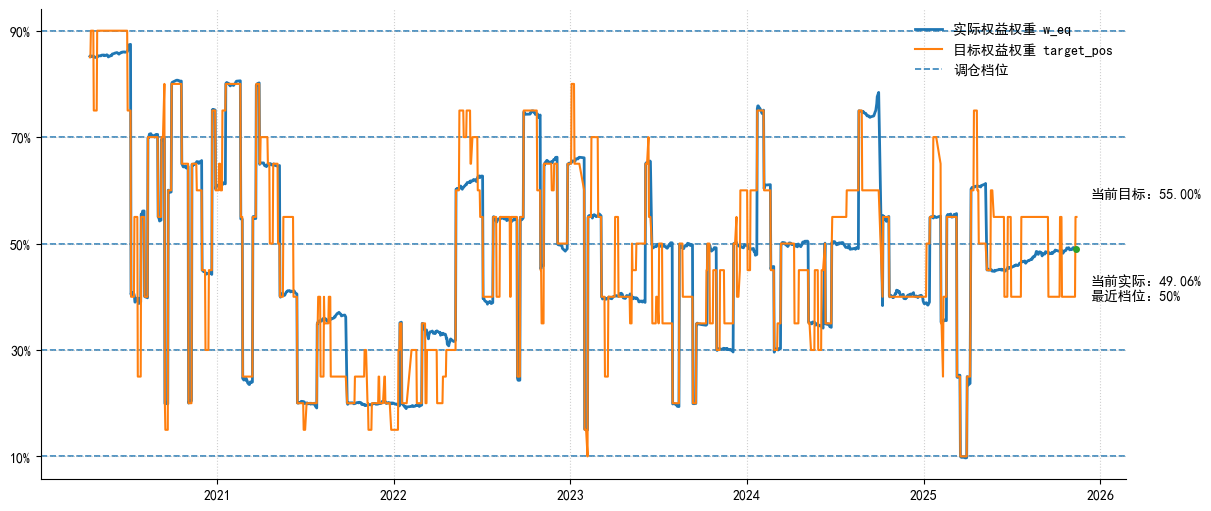

In [10]:
# ========== 绘制：仓位走势（含目标与档位） ==========
plot_weight_with_levels(run, pos_new=pos_new, show_target=True,
                        level_color=None, level_linewidth=1.2, level_alpha=0.9)

In [10]:
# ========== 状态输出：当前权重/信号 & 上次已执行调仓（含基准当前权重） ==========
idx = run.index
cur_date = idx[-1]
cur_w_eq = float(run.loc[cur_date, "w_eq"])
cur_w_bd = 1.0 - cur_w_eq
cur_target = float(pos_new.reindex(idx).loc[cur_date])
cur_macro = int(macro_sig.reindex(idx).loc[cur_date])
cur_sent  = int(sent_new.reindex(idx).loc[cur_date])

# 基准当前权重（年度 50/50 再平衡：新年首日开盘前重置）
years = idx.year
eq_v_b = 0.5; bd_v_b = 0.5
for i, t in enumerate(idx):
    if i > 0 and years[i] != years[i-1]:
        total_b = eq_v_b + bd_v_b
        eq_v_b = total_b * 0.5; bd_v_b = total_b * 0.5
    eq_v_b *= (1 + float(panel.loc[t, "ret_eq"]))
    bd_v_b *= (1 + float(panel.loc[t, "ret_bd"]))
bench_w_eq_cur = eq_v_b / (eq_v_b + bd_v_b)
bench_w_bd_cur = 1.0 - bench_w_eq_cur

# 上一次已执行调仓
exec_mask = run["executed"].astype(bool)
if exec_mask.any():
    last_date = idx[exec_mask].max()
    last_macro = int(macro_sig.reindex(idx).loc[last_date])
    last_sent  = int(sent_new.reindex(idx).loc[last_date])
    last_w_pre = float(run.loc[last_date, "w_pre"])
    last_target= float(pos_new.reindex(idx).loc[last_date])
    last_diff  = abs(last_target - last_w_pre)
else:
    last_date = None; last_macro = last_sent = np.nan
    last_w_pre = last_target = last_diff = np.nan

status = pd.DataFrame([
    {"场景":"当前(最新)", "日期":cur_date.date(),
     "权益权重(收盘后实际)":cur_w_eq, "债券权重(收盘后实际)":cur_w_bd,
     "目标权益权重":cur_target, "宏观信号":sig_text(cur_macro), "情绪信号":sig_text(cur_sent),
     "基准权益权重(收盘后实际)":bench_w_eq_cur, "基准债券权重(收盘后实际)":bench_w_bd_cur},
    {"场景":"上一次已执行调仓", "日期":(last_date.date() if last_date is not None else None),
     "权益权重(收盘后实际)":np.nan, "债券权重(收盘后实际)":np.nan,
     "目标权益权重":last_target, "宏观信号":sig_text(last_macro), "情绪信号":sig_text(last_sent)}
])
display(status)

last_detail = pd.DataFrame([{
    "日期": (last_date.date() if last_date is not None else None),
    "当日执行前权益权重 w_pre": last_w_pre,
    "当日目标权益权重 target": last_target,
    "真实口径变动 |target - w_pre|": last_diff
}])
display(last_detail)

snap = pd.DataFrame({
    "macro_sig": macro_sig.reindex(idx),
    "sent_sig":  sent_new.reindex(idx),
    "target_pos": pos_new.reindex(idx),
    "executed": run["executed"].astype(int),
    "w_pre": run["w_pre"],
    "w_eq": run["w_eq"],
}).tail(15)
display(snap)

,场景,日期,权益权重(收盘后实际),债券权重(收盘后实际),目标权益权重,宏观信号,情绪信号,基准权益权重(收盘后实际),基准债券权重(收盘后实际)
0,当前(最新),2025-09-26,0.481636,0.518364,0.40,中性/惯性(0),强避险(-2),0.539576,0.460424
1,上一次已执行调仓,2025-05-12,NaN,NaN,0.45,中性/惯性(0),偏避险(-1),NaN,NaN


,日期,当日执行前权益权重 w_pre,当日目标权益权重 target,真实口径变动 |target - w_pre|
0,2025-05-12,0.612948,0.45,0.162948


,macro_sig,sent_sig,target_pos,executed,w_pre,w_eq
Date,,,,,,
2025-09-08,1,-2,0.55,0,0.481357,0.480110
2025-09-09,1,-2,0.55,0,0.480110,0.480688
2025-09-10,1,-2,0.55,0,0.480688,0.484724
2025-09-11,1,-2,0.55,0,0.484724,0.484277
2025-09-12,1,-2,0.55,0,0.484277,0.483467
2025-09-15,1,-2,0.55,0,0.483467,0.483430
2025-09-16,0,-2,0.40,0,0.483430,0.484082
2025-09-17,0,-2,0.40,0,0.484082,0.481266
2025-09-18,0,-2,0.40,0,0.481266,0.480770


In [11]:
# ========== 可选导出 Excel ==========
if EXPORT_EXCEL:
    with pd.ExcelWriter(EXPORT_PATH, engine="xlsxwriter") as writer:
        pd.DataFrame(perf_comp).to_excel(writer, sheet_name="Perf_Comp")
        exec_summary.to_excel(writer, sheet_name="Exec_Summary", index=False)
        pd.DataFrame({"Benchmark_NAV": bench}).to_excel(writer, sheet_name="Benchmark")
        run.to_excel(writer, sheet_name="Daily", index=True)
        pd.DataFrame({"macro_sig":macro_sig,"sent_new":sent_new,"pos_new":pos_new}).to_excel(writer, sheet_name="Signals", index=True)
        period_table.to_excel(writer, sheet_name="Recent_5_20_250", index=False)
        status.to_excel(writer, sheet_name="Status", index=False)
        snap.reset_index().rename(columns={"index":"Date"}).to_excel(writer, sheet_name="Recent15", index=False)
    print(f"Excel exported: {EXPORT_PATH.resolve()}")